In [12]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
class SOM(object):
    def __init__(self,h,w,dim_feat):
        """
            Construction of a zero-filled SOM.
            h,w,dim_feat: constructs a (h,w,dim_feat) SOM.
        """
        self.shape = (h,w,dim_feat)
        self.som = np.zeros((h,w,dim_feat))
        
        # Training parameters
        self.L0 = 0.0
        self.lam = 0.0
        self.sigma0 = 0.0
            
    def train(self,data,L0,lam,sigma0,initializer=np.random.rand):
        """ 
            Training procedure for a SOM.
            data: a N*d matrix, N the number of examples, 
                  d the same as dim_feat=self.shape[2].
            L0,lam,sigma0: training parameters.
            initializer: a function taking h,w and dim_feat (*self.shape) as 
                         parameters and returning an initial (h,w,dim_feat) tensor.
        """
        self.L0 = L0
        self.lam = lam
        self.sigma0 = sigma0
        self.data = data

        self.som = initializer(*self.shape)

        for t in itertools.count():
            if self.sigma(t) < 1.0:
                break

            i_data =  np.random.choice(range(len(data)))

            bmu = self.find_bmu(data[i_data])
            self.update_som(bmu,data[i_data],t)
        
    def find_bmu(self, input_vec):
        """
            Find the Best Matching Unit of a given input vector.
            input_vec: a d=dim_feat=self.shape[2] input vector.
        """
        list_bmu = []
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                dist = np.linalg.norm((input_vec-self.som[y,x]))
                list_bmu.append(((y,x),dist))
        list_bmu.sort(key=lambda x: x[1])
        return list_bmu[0][0]
    
    def update_bmu(self,bmu,input_vector,t):
        """
            Update rule for the BMU.
            bmu: (y,x) BMU's coordinates.
            input_vector: current data vector.
            t: current time.
        """
        self.som[bmu] += self.L(t)*(input_vector-self.som[bmu])
    
    def update_som(self,bmu,input_vector,t):
        """ 
            Calls the update rule on each cell.
            bmu: (y,x) BMU's coordinates.
            input_vector: current data vector.
            t: current time.
        """
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                dist_to_bmu = np.linalg.norm((np.array(bmu)-np.array((y,x))))
                self.update_cell((y,x),dist_to_bmu,input_vector,t)
    
    def update_cell(self,cell,dist_to_bmu,input_vector,t):
        """ 
            Computes the update rule on a cell.
            cell: (y,x) cell's coordinates.
            dist_to_bmu: L2 distance from cell to bmu.
            input_vector: current data vector.
            t: current time.
        """
        self.som[cell] += self.N(dist_to_bmu,t)*self.L(t)*(input_vector-self.som[cell])
    
    def N(self,dist_to_bmu,t):
        """ 
            Computes the neighbouring penalty.
            dist_to_bmu: L2 distance to bmu.
            t: current time.
        """
        curr_sigma = self.sigma(t)
        return np.exp(-(dist_to_bmu**2)/(2*curr_sigma**2))
    
    def sigma(self, t):
        """
            Neighbouring radius formula.
            t: current time.
        """
        return self.sigma0*np.exp(-t/self.lam)

    def L(self, t):
        """
            Learning rate formula.
            t: current time.
        """
        return self.L0*np.exp(-t/self.lam)
    
    def get_bmu(self):
        """ 
            Get the BMU list of the SOM.
            It uses the data fed at last training.
        """
        bmu_list = []
        for input_vector in self.data:
            bmu = self.find_bmu(input_vector)
            bmu_list.append(bmu)
        
        return bmu_list

In [59]:
# load iris dataset
dataset = pd.read_csv('E:/Academic/Neural Networks/Assignment_2/iris.txt', delimiter=',', names = ['a','b','c','d','y'])

In [60]:
X = dataset.iloc[:,0:4].values
Y = dataset.iloc[:,4].values

In [61]:
som_iris = SOM(6,6,4)
som_iris.train(X,L0=0.8,lam=1e2,sigma0=5)

In [62]:
bmu_list = som_iris.get_bmu()

In [90]:
temp_dataset = dataset
temp_dataset['cluster'] = bmu_list

In [110]:
#group all iris data tuples per bmu (best matching unit) and extract most frequent target associated to each cell
#resulting object is in descending order so that the first element is the most frequently-occurring class label in value_counts
df = temp_dataset.groupby('cluster')['y'].value_counts().reset_index(name='v')
df = df.drop_duplicates('cluster')[['cluster','y']].reset_index(drop=True)

In [111]:
df.head(31)

,cluster,y
0,"(0, 0)",2
1,"(0, 1)",2
2,"(0, 2)",2
3,"(0, 3)",3
4,"(0, 4)",3
5,"(0, 5)",3
6,"(1, 1)",2
7,"(1, 2)",2
8,"(1, 4)",3
9,"(1, 5)",3


In [113]:
#initilaize majority matrix
result_map = np.zeros([6,6],dtype=np.int)

In [123]:
# fill majority matrix with the most frequently-occurring class label
counter = 0
for i in range(len(result_map)):
    for j in range(len(result_map[i])):
        if len(df[df['cluster'] == (i,j)]) == 0:
            result_map[i][j] = 0
        else:
            result_map[i][j] = df[df['cluster'] == (i,j)]['y'][counter]
            counter += 1

In [124]:
result_map

array([[2, 2, 2, 3, 3, 3],
       [0, 2, 2, 0, 3, 3],
       [0, 0, 2, 2, 3, 3],
       [1, 0, 0, 2, 2, 2],
       [1, 1, 0, 2, 2, 2],
       [1, 1, 0, 2, 2, 2]])

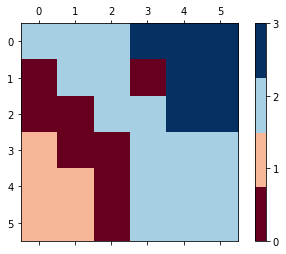

In [138]:
fig = plt.figure()
subplot = fig.add_subplot(111)
#get discrete colormap
cmap = plt.get_cmap('RdBu', 4)
cax = subplot.matshow(result_map, cmap=cmap)
fig.colorbar(cax, ticks=np.arange(0,4))
plt.show()

In [ ]:
# 0 means that there are no input vectors associated to the cell 